# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug


In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip # run one time only

In [5]:
sagemaker_session = sagemaker.Session()

In [6]:
bucket = "3rd-project"
prefix = "data/dogImages"
os.environ["DEFAULT_S3_BUCKET"] = bucket

In [ ]:
# run one time only
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [12]:
training_path= f"s3://{bucket}/data/dogImages/"
s3_output_dir = f"s3://{bucket}/output/"
s3_model_dir = f"s3://{bucket}/model/"

os.environ['SM_CHANNEL_TRAIN']=training_path
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir


In [21]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": IntegerParameter(2, 4)
}


objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [22]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=sagemaker.get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    base_job_name='hyper_tuning',
    instance_count=1,
    instance_type="ml.m5.large"
)



tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type='Auto'
)


In [23]:
# TODO: Fit your HP Tuner
tuner.fit({'train': training_path}, wait=True) # TODO: Remember to include your data channels

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [24]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator() 

best_estimator.hyperparameters()


2023-04-10 01:06:57 Starting - Preparing the instances for training
2023-04-10 01:06:57 Downloading - Downloading input data
2023-04-10 01:06:57 Training - Training image download completed. Training in progress.
2023-04-10 01:06:57 Uploading - Uploading generated training model
2023-04-10 01:06:57 Completed - Resource reused by training job: pytorch-training-230410-0025-004-508b8dc1


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"32"',
 'epochs': '4',
 'lr': '0.02827111340786444',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hyper_tuning-2023-04-10-00-25-05-023"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-918471311970/hyper_tuning-2023-04-10-00-25-05-023/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [25]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts


rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

[2023-04-10 01:27:40.092 pytorch-1-8-gpu-py36-ml-m5-large-f6c3d7d670ee91b6cbdc84ad69d6:1405 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [33]:
hyperparameters = {
    "batch_size": 32, #From Previous tuner
    "epochs": 4, #From previous tuner
    "lr":  0.02827111340786444 #From Previous tuner
}

In [34]:
#Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="train-script",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters = hyperparameters,
    framework_version="1.8",
    py_version="py36",
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)

In [37]:
estimator.fit({"train":training_path}, wait = True)

INFO:sagemaker:Creating training-job with name: train-script-2023-04-10-02-12-00-770


2023-04-10 02:12:00 Starting - Starting the training job...
2023-04-10 02:12:28 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-04-10 02:13:28 Downloading - Downloading input data......
2023-04-10 02:14:28 Training - Downloading the training image...............
2023-04-10 02:17:03 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-10 02:17:14,908 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-10 02:17:14,941 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-10 02:17:14,945 sagemaker_pytorch_container.training INFO     Invoking user training scri

In [ ]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

In [41]:
# Plot a debugging output:

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts


session = boto3.session.Session()
region = session.region_name


training_job_name = estimator.latest_training_job.name

print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
# View report
print(f"You will find the profiler report in {rule_output_path}")

Training jobname: train-script-2023-04-10-02-12-00-770
Region: us-east-1
[2023-04-10 02:58:35.306 pytorch-1-8-gpu-py36-ml-m5-large-f6c3d7d670ee91b6cbdc84ad69d6:1405 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-918471311970/train-script-2023-04-10-02-12-00-770/debug-output
[2023-04-10 02:58:35.749 pytorch-1-8-gpu-py36-ml-m5-large-f6c3d7d670ee91b6cbdc84ad69d6:1405 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-10 02:58:36.771 pytorch-1-8-gpu-py36-ml-m5-large-f6c3d7d670ee91b6cbdc84ad69d6:1405 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_inpu

You will find the profiler report in s3://sagemaker-us-east-1-918471311970/train-script-2023-04-10-02-12-00-770/rule-output


In [42]:
! aws s3 ls {rule_output_path} --recursive

2023-04-10 02:24:14     423940 train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-10 02:24:13     280412 train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-10 02:24:09        535 train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-10 02:24:09      14656 train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-10 02:24:09       2055 train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-10 02:24:09        130 train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-04-10 02:24:09        962 train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2023

In [43]:
! aws s3 cp {rule_output_path} ./ --recursive


download: s3://sagemaker-us-east-1-918471311970/train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-918471311970/train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-918471311970/train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-918471311970/train-script-2023-04-10-02-12-00-770/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-918471311970/train-script-2023-04-10-02-12-00-770/r

In [ ]:
import IPython

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
# Display Debugger Profiling Report 
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [61]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.g4dn.xlarge")  

INFO:sagemaker:Creating model with name: train-script-2023-04-10-03-33-07-364
INFO:sagemaker:Creating endpoint with name train-script-2023-04-10-03-33-07-364


----------!

In [62]:
predictor.endpoint_name

'train-script-2023-04-10-03-33-07-364'

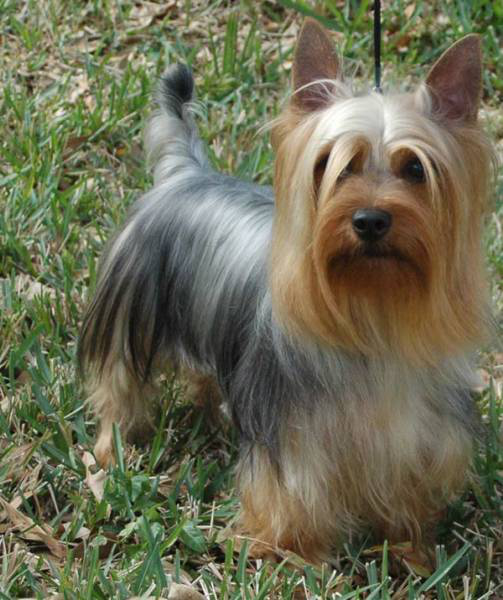

In [63]:
from PIL import Image
import io

with open("./dogImages/test/127.Silky_terrier/Silky_terrier_08040.jpg", "rb") as f: 
    image = f.read()
Image.open(io.BytesIO(image))

In [ ]:
res=predictor.predict(image)

In [59]:
import numpy as np

np.argmax(res,1) + 1

array([127])


In [66]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: train-script-2023-04-10-03-33-07-364
INFO:sagemaker:Deleting endpoint with name: train-script-2023-04-10-03-33-07-364
